<div style="text-align: center">
    <div style="font-size: xxx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">
        Signal Processing
    </div>
    <div style="font-size: x-large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">
        Spectral Analysis + Preprocessing
    </div>
</div>

In [1]:
# Cell 0 - Preparation: load packages, set some basic options  
%matplotlib inline
import obspy
from obspy.signal.invsim import cosine_taper 
from obspy.signal.filter import lowpass
from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime
from matplotlib import rcParams
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 15, 7
rcParams["figure.subplot.hspace"] = (0.5)

## The sampling theorem

In the digital world, we have neither continuous nor periodic signals. We always work with sampled signals. Therefore, we need to define some terms characterising the sampling:   
* The **sampling interval** is the temporal distance $\Delta t$ between the single sample values. The position on the time axis of one sample $k$ of the signal is thus given as $t = k\Delta t$ with $k=[1,2, ..., N]$ and $N$ being the maximum number of samples within the signal.  
* The **sampling rate** - also called the **sampling frequency** - is $f_s=1/\Delta t$
* The **period** of the signal is then given as $T = N\Delta t$.
* Fourier coefficients of transformed signal have a spacing of: $\Delta f = 1/T$.   

The **sampling theorem** states that at least 2 samples per period are needed to correctly reproduce the highest frequency of a signal. Or in other words: A signal can only reproduced properly when it does not contain frequency components above one-half of the sampling frequency. This is the definition of the **Nyquist frequency**:

$$ f_{Ny} = \frac{1}{2\Delta t} = \frac{f_s}{2}$$

An important consequence of this theorem is the necessity to **low-pass filter data before resampling them** to a lower sample rate. The corner frequency of the low-pass filter is maximum the Nyquist frequency of the *new* sample rate. If this necessity is not considered, we obtain **aliasing** effects.

When dealing with spectral analysis, it should be clear that it is fundamentally based on the characterisitics and properties of the *[Fourier series/Fourier transformation](fourier_transform.ipynb)*. Make sure, that you have understood this lecture as well. 


---

### Nyquist frequency and aliasing

In the following cell, we first create a signal made of two different frequencies (4 and 8 Hz) and sampled at 20 Hz (black). Then, we downsample it to 10 Hz in two ways: first, we just reduce the sample rate (red); second, we low-pass filter the data before downsampling (green). Finally, all three signals are plotted in the time- and frequency-domain to see the effects.   

**Question**:

1. What are the Nyquist frequencies for the original and the downsampled data?

**Question**:

2. Comparing the original (black) with the purely downsampled data (red), what do you observe and can you explain it?

**Question**:

3. Comparing the original (black) with the low-passed and downsampled signal (green), what do you observe now?

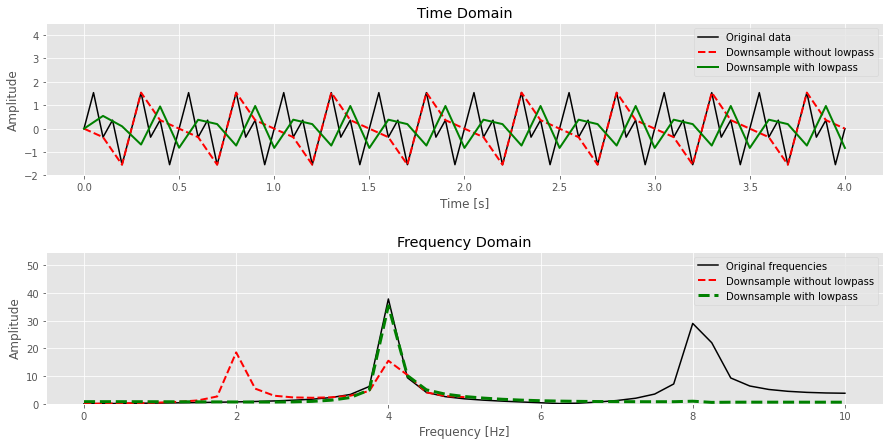

In [2]:
# Cell 1: downsampling + Nyquist
npts = 512                              # number of samples
nsec = 4                                # length of signal in seconds
df = 20                                 # sampling rate
fNy = df / 2.0                          # Nyquist frequency
fg1 = 8                                 # generator frequency 1 (initial: 8 Hz)
fg2 = 4                                 # generator frequency 2 (initial: 4 Hz)
time = np.linspace(0,nsec,(nsec*df)+1)  # time axis for plotting

y  = np.sin(2 * np.pi * fg1 * time)     # set up a test signal from two frequencies
y += np.sin(2 * np.pi * fg2 * time) 

# downsample to 10 Hz by taking every second element
y_2 = y[::2]

# downsample after lowpassing the signal
y_l = lowpass(y, 5.0, df=df, corners=4, zerophase=False)
y_new = y_l[::2]

y_f = np.fft.rfft(y)                    # transform all 3 signals into frequency domain 
y_f2 = np.fft.rfft(y_2)                 # applying Fourier transformation via FFT
y_fnew = np.fft.rfft(y_l)
freq = np.linspace(0, fNy, len(y_f))    # frequency axis for plotting

# plot
plt.subplot(211)
plt.plot(time, y, 'k', label="Original data", lw=1.5)
plt.plot(time[::2], y_2, 'r--', label="Downsample without lowpass", lw=2)
plt.plot(time[::2], y_new, 'g', label="Downsample with lowpass", lw=2)
plt.legend()
plt.ylim(-2, 4.5)
plt.title('Time Domain')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.subplot(212)
plt.plot(freq, abs(y_f), 'k', label="Original frequencies", lw=1.5)
plt.plot(freq[:len(y_f2)], abs(y_f2), 'r--', label="Downsample without lowpass", lw=2)
plt.plot(freq[:len(y_fnew)], abs(y_fnew), 'g--', label="Downsample with lowpass", lw=3)
plt.legend()
plt.ylim(0, 55)
plt.title('Frequency Domain')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')

plt.show()

---

### Spectral leakage

Now, we create a sinusoid with frequency 4 Hz sampled at 100 Hz, transfer it in the frequency-domain via FFT and plot both. 

**Question**:

4. What would you expect theoretically for the frequency-domain plot.

**Question**:

5. Enlarge the length of the time-domain signal by setting the variable $leng$ step by step higher. What do you observe in the plot for the frequency domain? Can you explain it?

**Question**:

6. In reality we cannot just enlarge the length of our signal. Can you think about a way to still get the same effect?

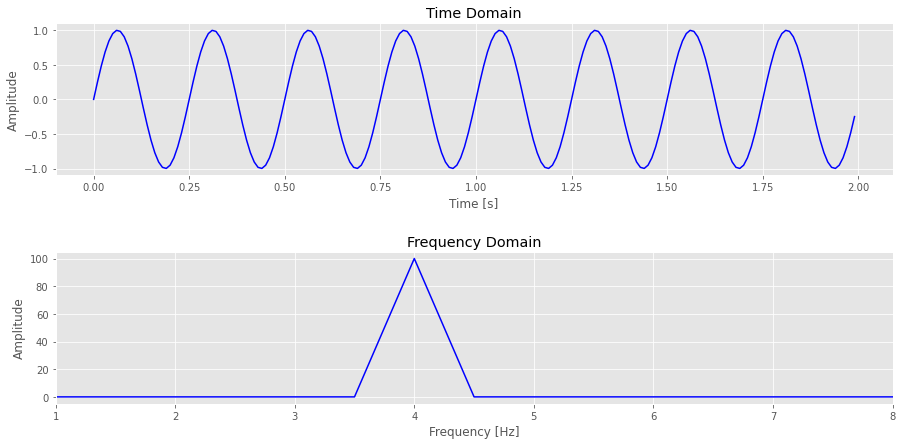

In [5]:
# Cell 2: spectral leakage
leng = 2.0                           # length of signal in seconds (initial: 2 s)
dt = 1./100.                         # sampling interval
ny = 1/(2.*dt)                       # Nyquist frequency
t = np.arange(0, leng, dt)           # time axis for plotting
sin  = np.sin(2 * 4 * np.pi * t)     # set up a sine wave as signal

Fsin = np.fft.rfft(sin)              # FFT to frequency domain
f = np.linspace(0, ny, len(Fsin))    # frequency axis for plotting

# plot
plt.subplot(211)
plt.plot(t, sin, 'b')
plt.title('Time Domain')
plt.ylim(-1.1,1.1)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.subplot(212)
plt.plot(f, abs(Fsin), 'b')
plt.xlim(1,8)
plt.title('Frequency Domain')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')

plt.show()

### Time-frequency plots - spectrograms 

So far, we analysed the data only in either time- or frequency-domain. Sometimes it is helpful to look at both dimensions together. Such a time-frequency plot is called **spectrogram**. In cell 3, we first download and prepare data from the $M_w$ 9.1 Tohoku earthquake from 11 March 2011. In cell 4, we then create a spectrogram from these data.    

**Question**:

7. What happens when you increase the number of sample points $NFFT$ in cell 4 and why?     

**Question**:

8. Zoom in to the start of the signal by changing $xstart$ and $xend$. Does a longer or shorter window length allow you to identify the start of the signal more easily? Why?     

**Question**:

9. Now adapt the time limits to look at the surface waves, what do you observe?

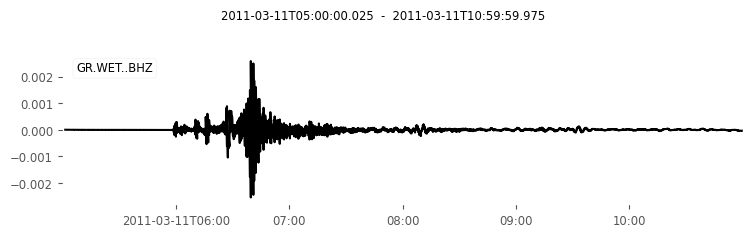

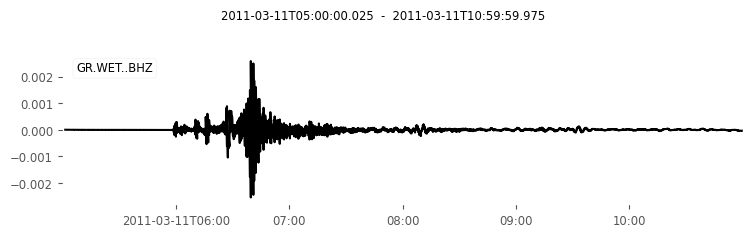

In [6]:
# Cell 3: prepare data from Tohoku earthquake. 
client = Client("BGR")
t1 = UTCDateTime("2011-03-11T05:00:00.000")
st = client.get_waveforms("GR", "WET", "", "BHZ", t1, t1 + 6 * 60 * 60, 
                          attach_response = True)
st.detrend('linear')
st.detrend('demean')
st.remove_response(output="VEL")
st.detrend('linear')
st.detrend('demean')
st.plot()

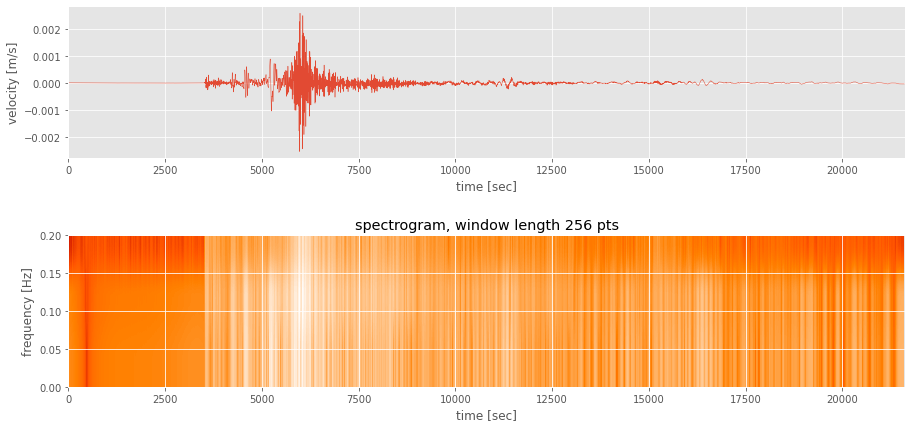

In [44]:
# Cell 4 - spectrogram
tr = st[0]
NFFT = 256    # length of spectrogram window in sample points (initial: 256)
# number of sample points that the sliding window overlaps, must be less than NFFT
noverlap = 50    #(initial:50)
xstart = 0    # x axis limits in the plot (initial: 0 sec)
xend = 21627  # max. length of signal: (initial: 21627 sec)

# plot
ax1 = plt.subplot(211)
plt.plot(tr.times(), tr.data, linewidth=0.5)
plt.xlabel('time [sec]')
plt.ylabel('velocity [m/s]')

plt.subplot(212, sharex=ax1)
plt.title('spectrogram, window length %s pts' % NFFT)
Pxx, freqs, bins, im = plt.specgram(
    tr.data, NFFT=NFFT, Fs=tr.stats.sampling_rate, 
    noverlap=noverlap,cmap=plt.cm.gist_heat)

# Pxx is the segments x freqs array of instantaneous power, freqs is
# the frequency vector, bins are the centers of the time bins in which
# the power is computed, and im is the matplotlib.image.AxesImage instance
plt.ylabel('frequency [Hz]')
plt.xlabel('time [sec]')
plt.ylim(0,0.2)

plt.xlim(xstart, xend)
plt.show()

The example above uses the `specgram` function of `matplotlib.pylab`. In case of very long signals or signals with a high sampling rate, this is highly recommended due to the high computational effort. In case of shorter time signals, `ObsPy` also offers a `spectrogram` function. An example can be found [here](https://docs.obspy.org/tutorial/code_snippets/plotting_spectrograms.html).

---

## Preprocessing data

The basics of the spectral analysis are the foundation for **preprocessing data**. Preprocessing data is an essential task before the data can be used for any scientific analysis. 
- instrument characteristic needs to be removed from the data
- we need to make sure that the data are in the ideal shape for the specific task. 

The 'good-practise rules' for preprocessing depend on the characteristics/properties of spectral analysis. They include the following steps in more or less this order:

- Merge data pieces
- Detrend and demean the data
- Taper the data
- Restitution, also called decomposition or instrument correction   
- Low-pass filtering
- Downsample/resample the data
- Cut the data to a specific window
- Pad with zeros

Not always all these steps  and sometimes further preprocessing steps are necessary, depending on the specific task the data shall be used for. However, these steps are the main and most important ones. The restitution is a very special process with a lot of details in its own. Therefore, we skip it here and refer to the [separate notebook on instrument correction](../geopy-teaching/lecture_19_obspy_instrument_response.ipynb).

---


### Windows and Tapers

Sometimes, we have a very long signal but only need a small portion of it, e.g. a recording of an earthquake in a file covering the entire day. Then, to speed up processing and make plots more clear, we need to cut that part, we are interested in. This is also called **windowing** the signal because it is similar to applying a boxcar/window function to the data in the frequency-domain (see the [notebook on filter basics](../geopy-teaching/lecture_15_theory_filter.ipynb) for more details).  

In Cell 5, you have several possibilities to set-up an inital signal. Just comment/uncomment the lines in the second code block as you want. In the fourth code block the taper is defined. Here, we use a simple $cos$ to taper. Working on real data using `ObsPy` you have several [taper windows](https://docs.obspy.org/master/packages/autogen/obspy.core.trace.Trace.taper.html) to chose from. In general, the percentage of taper applied has a much larger effect then the choosen window. 

**Question**:

10. Why do we apply a taper to the data and what is a taper actually?   

**Question**:

11. What happens at the beginning and end of the taper and what happens in the middle part?    

**Question**:

12. What happens when you increase the percentage of tapering?    

Before Taper
amplitude of first sample point:   0.9
amplitude of last sample point:  -0.9
After Taper
amplitude of first sample point:   0.0
amplitude of last sample point:  -0.0


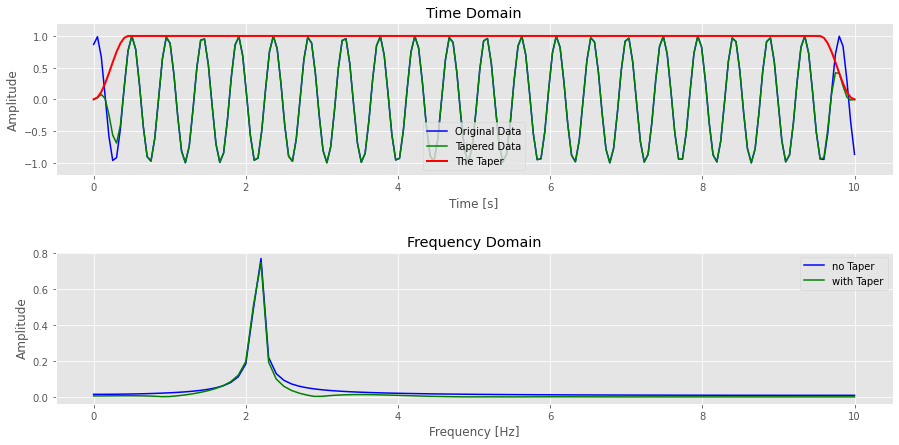

In [52]:
# Cell 5 - tapers  
samp = 200                                # number of sample point (initial: 200)
delta = 0.05                              # sample spacing (initial: 0.05)
freq1 = 2.15                              # generator freq to create signal (initial: 2.15)
freq2 = 7.8                               # generator freq to create signal (initial: 7.8)
temp = np.linspace(0.0, samp*delta, samp) # time axis in seconds

# generate freq1 Hz sine wave signal
dat = np.sin(freq1 * 2.0 * np.pi * temp)
# add an offset for the zero point of the sinewave
dat = np.sin(freq1 * 2.0 * np.pi * temp + np.pi/3)
## add another sinusoid to signal with freq2 Hz
#dat = dat + np.sin(freq2 * 2.0 * np.pi * temp + np.pi/3)
#noise_amplitude = 0.7
## add noise to the signal
#dat = dat + np.random.randn(len(dat)) * noise_amplitude 
# determine max. amplitude of data (for plotting)
maximum = max(dat)

print('Before Taper')
print('amplitude of first sample point:%6.1f' %dat[0])
print('amplitude of last sample point:%6.1f' %(dat[len(dat)-1]))

# percentage of taper applied [0. ; 1.] (initial: 0.1)
taper_percentage = 0.1
# define taper window
taper = cosine_taper(samp,taper_percentage)
# taper the signal
dat_taper = dat * taper

print('After Taper')
print('amplitude of first sample point:%6.1f' %dat_taper[0])
print('amplitude of last sample point:%6.1f' %(dat_taper[len(dat_taper)-1]))

# FFT data into frequency-domain
Fdat = np.fft.rfft(dat, n=samp)
Fdat_taper = np.fft.rfft(dat_taper, n=samp)
# x-axis in f-domain for plotting
xf = np.linspace(0.0, 1.0/(2.0*delta), int((samp/2)+1))

# plot
plt.subplot(211)
plt.title('Time Domain')
plt.plot(temp, dat, label="Original Data", color='b', linewidth=1.5)
plt.plot(temp, dat_taper, label="Tapered Data", color='g',linewidth=1.5)
plt.plot(temp, taper, label="The Taper", color='r', linewidth=2)
plt.legend(loc='lower center')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.ylim(-(maximum+0.2),maximum+0.2)

plt.subplot(212)
plt.title('Frequency Domain')
plt.plot(xf, 2.0/samp * np.abs(Fdat), color='b',label="no Taper",linewidth=1.5)
plt.plot(xf, 2.0/samp * np.abs(Fdat_taper), label="with Taper", color='g',linewidth=1.5)
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')

plt.show()

---

### Demean / detrend

Real data are definitely not perfect. Worse luck! So, they can have jumps, trends, offsets, spikes, etc. ... Luckily, the most common ones are easy to handle.    
In Cell 6 we load a stream which is included in the `ObsPy` installation as an example to start with. In the following cells, we artifically introduce some data errors and see how they blow-up our processing. As an example, we use a bandpass filter. `ObsPy` provide us with the right [tool](http://docs.obspy.org/packages/autogen/obspy.core.trace.Trace.detrend.html#obspy.core.trace.Trace.detrend) to correct our data before further (pre-)processing.

**Question**:

13. Run the cells and describe what effects you can see. Then uncomment the line *correction* and run the cells again. What do you observe.    

**Question**:

14. Can you explain, why all these spoilers blow-up the further processing?

3 Trace(s) in Stream:
BW.RJOB..EHZ | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples
BW.RJOB..EHN | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples
BW.RJOB..EHE | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples

BW.RJOB..EHZ | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples


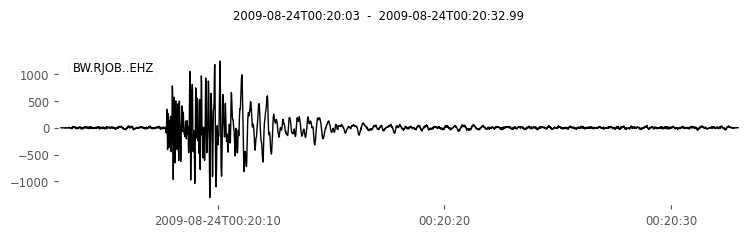

In [53]:
# Cell 6 - load the data
st = obspy.read()             # read in example seismogram included in obspy
print(st)
print('')
tr = st[0]                    # take only the vertical trace of the stream
print(tr)
tr.filter("highpass", freq=2) # removing long-period noise
tr.plot()
tr_safe = tr.copy()           # safety copy to not override our data

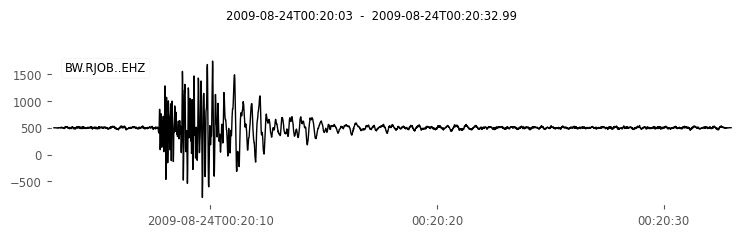

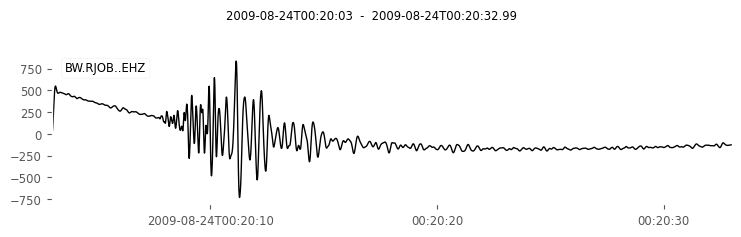

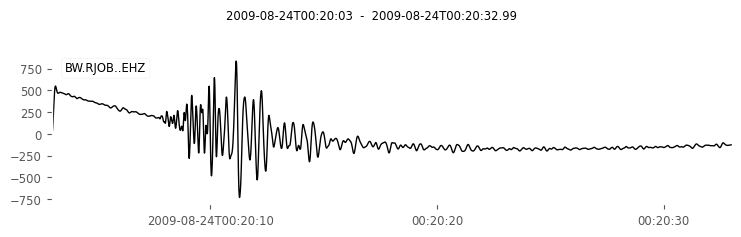

In [68]:
# Cell 7 - offsets 

tr = tr_safe.copy()       # load a fresh version of the data
tr.data += 500            # creating an offset
tr.plot()
#tr.detrend('demean')     # correction
tr.filter('bandpass', freqmin=0.01, freqmax=5)
tr.plot()

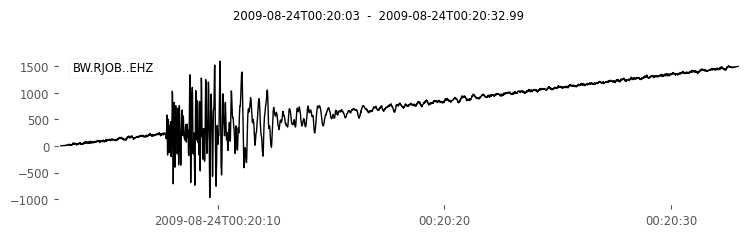

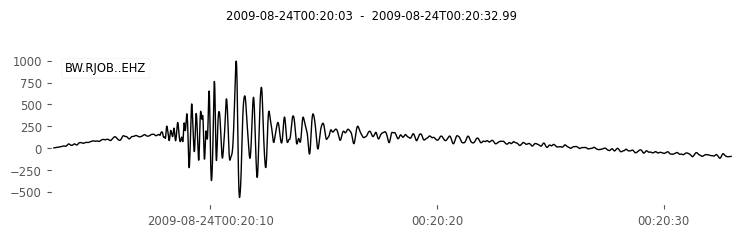

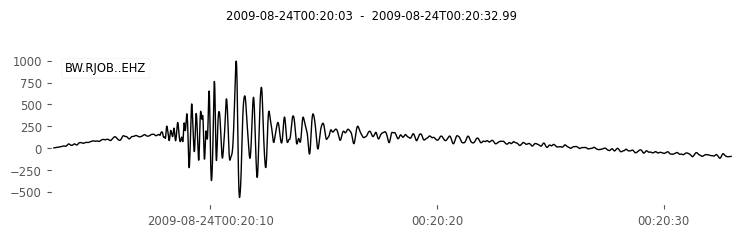

In [63]:
# Cell 8 - linear trend 

tr = tr_safe.copy()         # load a fresh version of the data
tr.data += 50. * tr.times() # creating a linear trend
tr.plot()
#tr.detrend('linear')       # correction
#tr.plot()
tr.filter('bandpass', freqmin=0.01, freqmax=5.)
tr.plot()

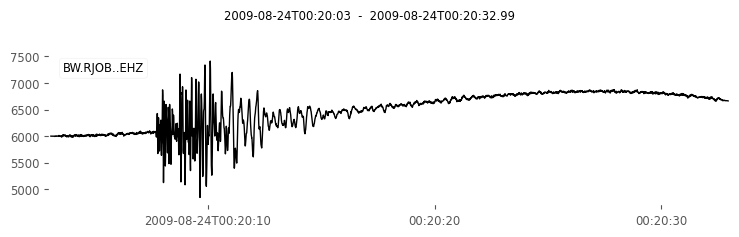

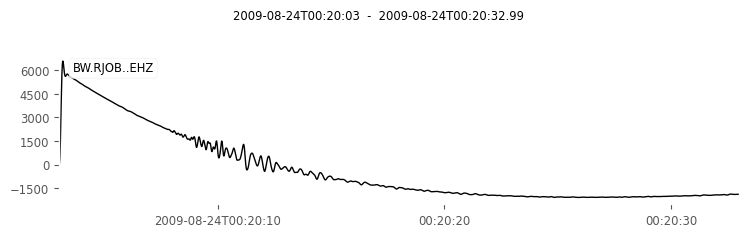

In [67]:
# Cell 9 - any polynomial trend

# load a fresh version of the data
tr = tr_safe.copy()
# "spoiling" the data
tr.data += 6000 + 4 * tr.times() ** 2
# further "spoiling" the data
tr.data -= 0.1 * tr.times() ** 3 + 0.00001 * tr.times() ** 5

tr.plot()
tmp = tr.copy()
tmp.filter('bandpass', freqmin=0.01, freqmax=5)
tmp.plot()

# taking the data as array out of trace container
data = tr.data                                           
# correct the spoiled data and plot+print it
#obspy.signal.detrend.polynomial(data, order=3, plot=True) 

### Next lecture: [Python - Obspy - Intro](lecture_17_obspy_intro.ipynb)

---
##### Authors:
* Stefanie Donner ([@stefdonner](https://github.com/stefdonner))
* Celine Hadziioannou ([@hadzii](https://github.com/hadzii))
* Ceri Nunn ([@cerinunn](https://github.com/cerinunn))
* Eva Eibl ([@evaeibl](https://github.com/evaeibl))
* [Julian Niedermeier](https://github.com/sleighsoft)

Seismo-Live: http://seismo-live.org